In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt





In [4]:

from google.colab import drive

drive.mount('/content/gdrive')

folder_path = "/content/gdrive/My Drive/vacances/CAT3"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#%%
train_set = datasets.ImageFolder(root=folder_path, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
#%% Définir la taille du lot (batch size)
batch_size = 64
input_dim=128
kernel_size=4
stride=2
latent_dim=1024



Mounted at /content/gdrive


In [41]:
batch_size = 64
input_dim=128
kernel_size=4
stride=2
latent_dim=1024

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Conv2d(3,32,kernel_size,stride)
        self.dim1=int((input_dim-kernel_size)/stride+1)
        self.fc2 = nn.Conv2d(32,64,4,2)
        self.dim2=int((self.dim1-kernel_size)/stride+1)
        self.fc21 = nn.Linear(self.dim2**2,latent_dim) # mean
        self.fc22 = nn.Linear(self.dim2**2,latent_dim) # variance
        self.fc3 = nn.Linear(latent_dim,self.dim2**2)
        self.fc4 = nn.ConvTranspose2d(64,32,kernel_size+1,stride)
        self.fc5 = nn.ConvTranspose2d(32, 3, kernel_size, stride)

    def encode(self, x):
        h0=F.relu(self.fc1(x))
        h1 = F.sigmoid(self.fc2(h0))
        # h1 = h1.view()
        h1 = h1.view(h1.size(0),h1.size(1),1,-1)
        return self.fc21(h1), self.fc22(h1) # returns mean and variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) # returns sampled latent variable z

    def decode(self, z):
        h3 = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h3)) # returns reconstructed image

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = F.relu(self.fc3(z))
        z = z.view(z.size(0),z.size(1),int((self.dim1-kernel_size)/stride+1),int((self.dim1-kernel_size)/stride+1))
        return self.decode(z), mu, logvar





In [42]:
def loss_function(x,recon_x , mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

#%%

def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        u=0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)

            loss = loss_function(x, x_hat, mean, log_var)
            overall_loss += loss.item()
            if u%5000==0:
                print(batch_idx/len(train_loader), overall_loss)
            loss.backward()
            optimizer.step()

        print("Epoch", epoch + 1, "Average Loss:", overall_loss / (batch_idx * batch_size))
    return overall_loss



In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [25]:
model = torch.load('/content/gdrive/My Drive/vacances/vae_24ep.pt', map_location=torch.device('cpu'))


In [49]:
train(model, optimizer, epochs=20,device=device)


0.0 1767673.0
0.008620689655172414 3474625.0
0.017241379310344827 5234492.125
0.02586206896551724 6986828.0
0.034482758620689655 8747712.25
0.04310344827586207 10484801.75
0.05172413793103448 12231675.5
0.0603448275862069 13961845.25
0.06896551724137931 15655443.5
0.07758620689655173 17409932.25
0.08620689655172414 19129935.375
0.09482758620689655 20884352.75
0.10344827586206896 22614779.25
0.11206896551724138 24368669.125
0.1206896551724138 26097053.0
0.12931034482758622 27851533.75
0.13793103448275862 29637595.625
0.14655172413793102 31373555.625
0.15517241379310345 33108403.5
0.16379310344827586 34869467.75
0.1724137931034483 36585022.125
0.1810344827586207 38292089.0
0.1896551724137931 40064832.375
0.19827586206896552 41764516.625
0.20689655172413793 43501696.5
0.21551724137931033 45226189.375
0.22413793103448276 47006895.875
0.23275862068965517 48701943.0
0.2413793103448276 50450022.0
0.25 52223227.0
0.25862068965517243 54016802.875
0.2672413793103448 55786942.375
0.27586206896551

200342787.75

In [57]:
file_path = "/content/gdrive/My Drive/vacances/vae_2layerconv_50ep.pt"
torch.save(model, file_path)

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])


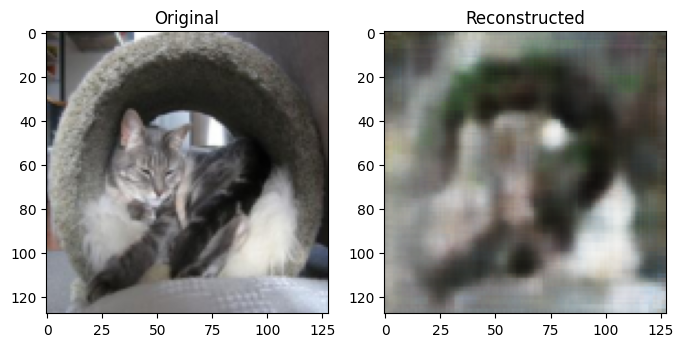

In [56]:
# convert the tensors to numpy arrays and reshape them into images
import random
image,_ = train_set.__getitem__(random.randint(0,100))
with torch.no_grad():
    image = image.to(device)
    print(image.size())
    recon_image, mu, logvar = model(image.unsqueeze(0))
    print(recon_image.size())
image =image.cpu().numpy()
image = np.transpose(image, (1, 2, 0))

recon_image = recon_image.cpu().numpy()[0]
recon_image = np.transpose(recon_image, (1, 2, 0))

# display the original image and the reconstructed image side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[1].imshow(recon_image)
axes[1].set_title("Reconstructed")
plt.show()
#%% test visuel
